In [1]:
import sys, os
import theano
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
import scanpy as sc
import pandas as pd
sc.settings.autosave=False
sc.settings.autoshow=True

maxgenes=10000
n_iterations=1000
#adatapath=os.path.expanduser('/scrapp2/mtschmitz/5k_pbmc_v3')
#genomename="refdata-celranger-mmul8-toplevel"
#genomename=''
#samplename='5kPBMC'


adatapaths=['/home/mt/Downloads/1k_hgmm','/scrapp2/mtschmitz/5k_pbmc_v3','/scrapp2/mtschmitz/E40_motor_Out','E50_motor_Out','E65_motor_Out','E80motor_Out','E100motor_Out']
genomenames=['','',"refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel",
            "refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel"]
samplenames=['1kHGMM','5kPCMB','E40','E50','E65','E80','E100']
adatapath=adatapaths[0]
#genomename="refdata-celranger-mmul8-toplevel"
genomename=''
samplename=samplenames[0]


Trying to set attribute `.var` of view, making a copy.


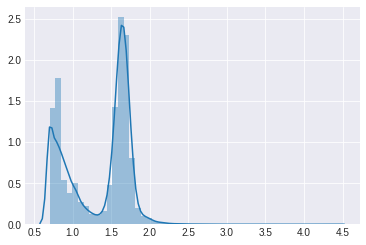

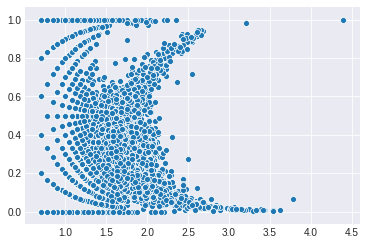

In [2]:
adata = sc.read_10x_mtx(os.path.join(adatapath,'outs/raw_feature_bc_matrix',genomename),cache=False)
bcs=list(pd.read_csv(os.path.join(adatapath,'outs/filtered_feature_bc_matrix',genomename,'barcodes.tsv.gz')).iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=10,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
#adata=adata[adata.obs.n_counts.argsort(),:]
adata.var['Mouse'] = ['mm10' in x for x in adata.var.index]

cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]
adata.obs['PercentM'] =adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1)

ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].X.sum(1).A1)
sns.distplot(ambient_counts)
plt.show()
sns.scatterplot(ambient_counts,np.array(adata[[x not in bcs for x in adata.obs.index],:].obs['PercentM']))
plt.show()
#adata=adata[:,(-adata[junk_inds,:].X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])]]
betaAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()
betaAmbientDict=dict(zip(list(adata.var.index), betaAmbient.A1))




sc.settings.figdir=os.path.expanduser('~/figs/'+samplename)
if not os.path.exists(sc.settings.figdir):
        os.makedirs(sc.settings.figdir)

#adata._inplace_subset_obs(np.random.choice(adata.obs.index,10000,replace=False))
#adata._inplace_subset_var(np.random.choice(adata.var.index,4000,replace=False))
#sc.pp.filter_genes(adata, min_cells=50,inplace=True)
#sc.pp.filter_cells(adata,min_counts=5,inplace=True)

Trying to set attribute `.var` of view, making a copy.


AnnData object with n_obs × n_vars = 1073 × 11993 
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
AnnData object with n_obs × n_vars = 1073 × 11993 
    obs: 'n_counts', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9'
    var: 'gene_ids', 'feature_types', 'n_cells', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9'
[[1.         0.39261003]
 [0.39261003 1.        ]]
[[1.         0.39935605]
 [0.39935605 1.        ]]


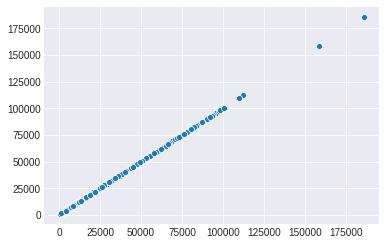

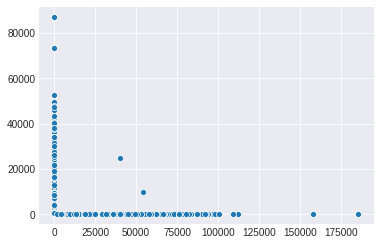

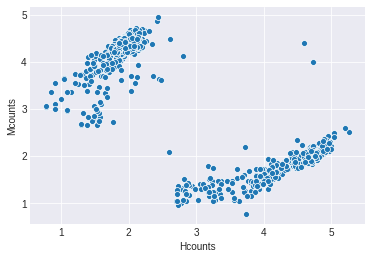

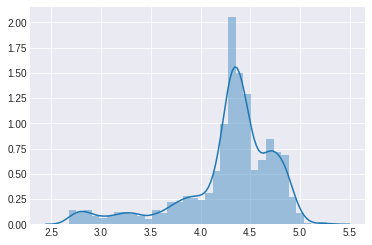

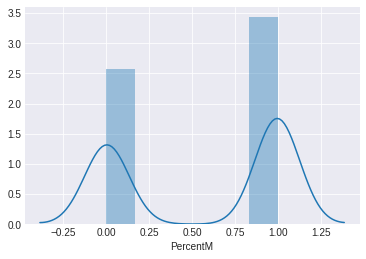

In [5]:
adata=sc.read_10x_mtx(os.path.join(adatapath,'outs/filtered_feature_bc_matrix'),cache=False)
sc.pp.filter_genes(adata, min_cells=10,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
freshadata=sc.read_h5ad(os.path.join(adatapath,'outs/ambientsubtracted.h5ad'))
sc.pp.filter_genes(freshadata, min_cells=10,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=5,inplace=True)
cells=list(set(adata.obs.index) & set(freshadata.obs.index)) 
genes=list(set(adata.var.index) & set(freshadata.var.index)) 
freshadata._inplace_subset_obs(cells)
freshadata._inplace_subset_var(genes)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var(genes)


print(adata)
print(freshadata)

print(np.corrcoef((adata.X-freshadata.X).sum(0),freshadata.var['lda_9']))
print(np.corrcoef((adata.X-freshadata.X).sum(0),[betaAmbientDict[i] for i in freshadata.var.index]))

sns.scatterplot(freshadata.X.sum(1).A1,adata.X.sum(1).A1)
plt.show()
adata.var['Mouse'] = ['mm10' in x for x in adata.var.index]
adata.obs['PercentM'] =adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1)
adata.obs['Mcounts'] =adata[:,list(adata.var['Mouse'])].X.sum(1)
adata.obs['Hcounts'] =adata[:,list(np.invert(adata.var['Mouse']))].X.sum(1)

sns.scatterplot(np.array(adata.obs['Hcounts']),np.array(adata.obs['Mcounts']))
plt.show()
sns.scatterplot(np.log10(adata.obs['Hcounts']+1),np.log10(adata.obs['Mcounts']+1))
plt.show()
sns.distplot(np.log10(adata.X.sum(1)))
plt.show()
sns.distplot(adata.obs['PercentM'])
plt.show()


In [142]:
freshadata.obs.columns
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
tp=theta*phi.T
tp9=theta[:,9]*phi[:,9].T
tp08=theta[:,0:9]*phi[:,0:9].T
invtp08=1-tp08
np.corrcoef(freshadata.X[10,:].toarray(),tp08[10,:])

array([[1.       , 0.9617407],
       [0.9617407, 1.       ]])

In [143]:
import sklearn
lda=sklearn.decomposition.LatentDirichletAllocation()
lda.fit(freshadata.X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [144]:
lbeta=lda.components_ /lda.components_.sum(axis=1)[:, np.newaxis]
ltheta=lda.transform(freshadata.X)

In [145]:
np.corrcoef(freshadata.X[100,:].toarray(),(np.matrix(ltheta)*np.matrix(lbeta))[100,:])

array([[1.        , 0.98590178],
       [0.98590178, 1.        ]])

In [ ]:
sns.distplot((adata.X-freshadata.X).sum(1))

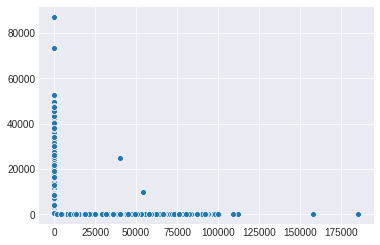

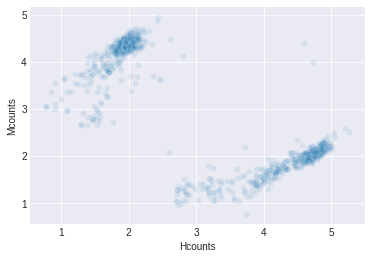

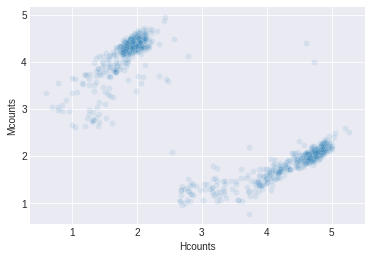

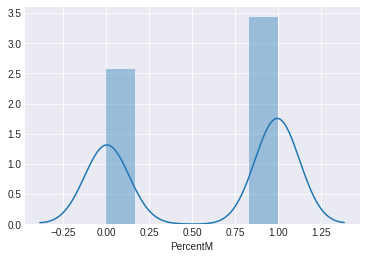

In [6]:
freshadata.var['Mouse'] = ['mm10' in x for x in freshadata.var.index]
freshadata.obs['PercentM'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)
freshadata.obs['Mcounts'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)
freshadata.obs['Hcounts'] =freshadata[:,list(np.invert(freshadata.var['Mouse']))].X.sum(1)
freshadata.obs['BambMult']=(freshadata.X*np.array([betaAmbientDict[i] for i in freshadata.var.index]))
sns.scatterplot(np.array(freshadata.obs['Hcounts']),np.array(freshadata.obs['Mcounts']))
plt.show()
sns.scatterplot(np.log10(adata.obs['Hcounts']+1),np.log10(adata.obs['Mcounts']+1),alpha=.1)
plt.show()
sns.scatterplot(np.log10(freshadata.obs['Hcounts']+1),np.log10(freshadata.obs['Mcounts']+1),alpha=.1)
plt.show()
sns.distplot(freshadata.obs['PercentM'])
plt.show()


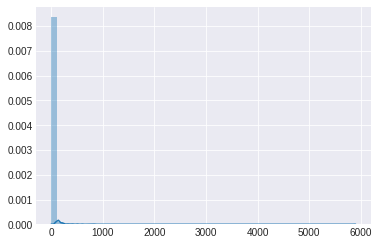

[[1.         0.44807044]
 [0.44807044 1.        ]]
[[1.         0.97524792]
 [0.97524792 1.        ]]


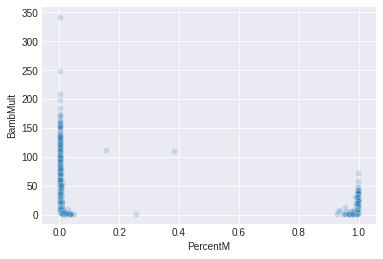

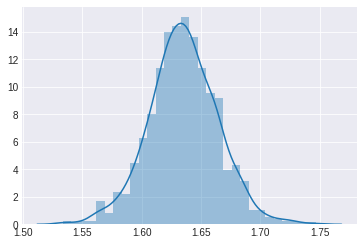

In [7]:
humanmousegenes=adata[adata.obs['PercentM']<.2,][:,adata.var['Mouse']]
sns.distplot(freshadata[freshadata.obs['PercentM']<.2,][:,freshadata.var['Mouse']].X.sum(0))
plt.show()
print(np.corrcoef( humanmousegenes.X.sum(0) ,[betaAmbientDict[i] for i in humanmousegenes.var.index]))
mousehumangenes=adata[adata.obs['PercentM']>.8,][:,np.invert(adata.var['Mouse'])]
print(np.corrcoef( mousehumangenes.X.sum(0) ,[betaAmbientDict[i] for i in mousehumangenes.var.index]))
sns.scatterplot(freshadata.obs['PercentM'],freshadata.obs['BambMult'],alpha=.2)
plt.show()
(adata.X-freshadata.X).sum(0).sum()
sns.distplot(np.log10(freshadata.obs['lda_9']*freshadata.obs['n_counts']))

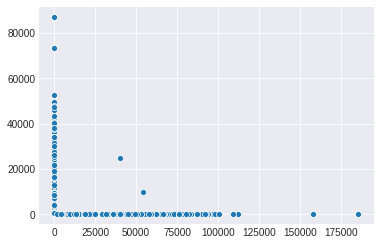

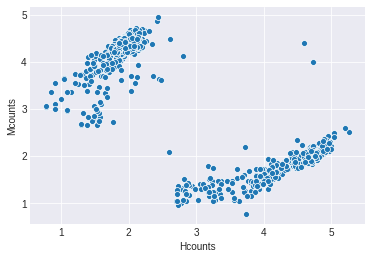

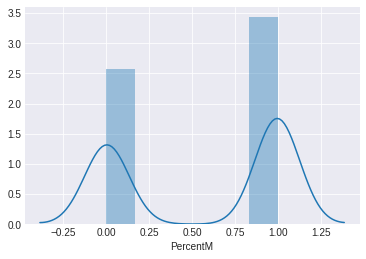

In [8]:
sns.scatterplot(np.array(adata.obs['Hcounts']),np.array(adata.obs['Mcounts']))
plt.show()
sns.scatterplot(np.log10(adata.obs['Hcounts']+1),np.log10(adata.obs['Mcounts']+1))
plt.show()
sns.distplot(adata.obs['PercentM'])
plt.show()


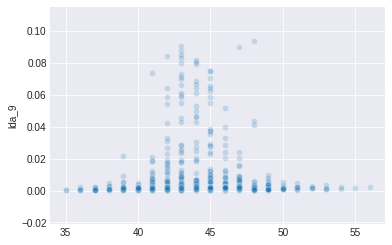

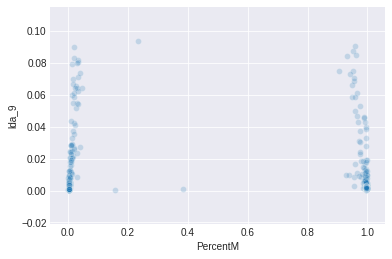

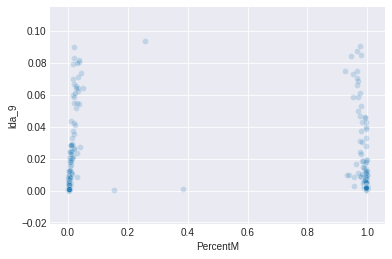

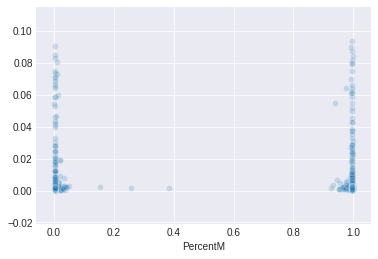

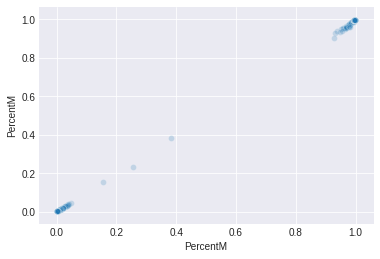

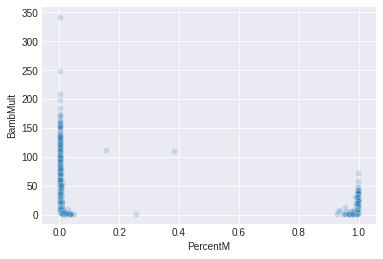

In [9]:
sns.scatterplot((adata.X-freshadata.X).sum(1).A1,freshadata.obs['lda_9'],alpha=.2)
plt.show()
sns.scatterplot(adata.obs['PercentM'],freshadata.obs['lda_9'],alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],freshadata.obs['lda_9'],alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],np.random.permutation(list(freshadata.obs['lda_9'])),alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],adata.obs['PercentM'],alpha=.2)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],freshadata.obs['BambMult'],alpha=.2)
plt.show()



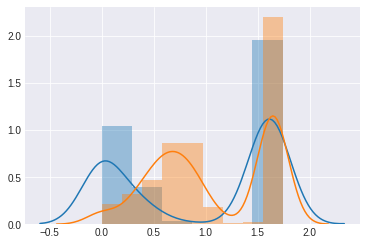

In [10]:
sns.distplot(np.log10((adata[:,adata.var['Mouse']].X-freshadata[:,adata.var['Mouse']].X).sum(1)+1))
sns.distplot(np.log10((adata[:,np.invert(adata.var['Mouse'])].X-freshadata[:,np.invert(adata.var['Mouse'])].X).sum(1)+1))


0.0004243608

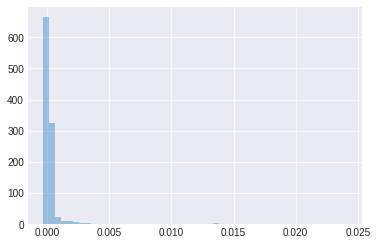

In [11]:
sns.distplot(freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)-adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1),kde=False)
np.mean(freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)-adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1))


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

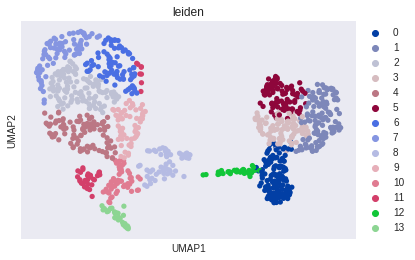

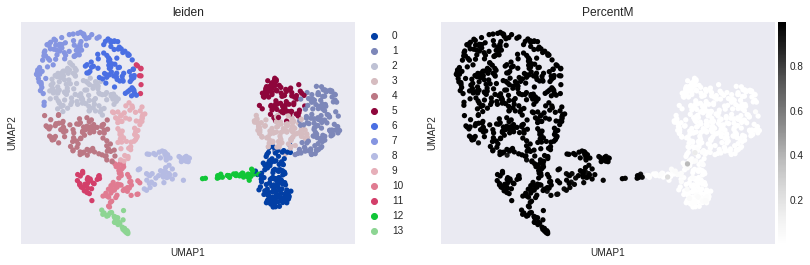

In [12]:
sc.pp.filter_genes(adata,min_counts=2,inplace=True)
sc.pp.filter_cells(adata,min_counts=100,inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=5000,inplace=True)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['leiden','PercentM'])


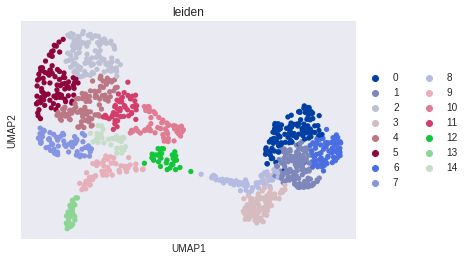

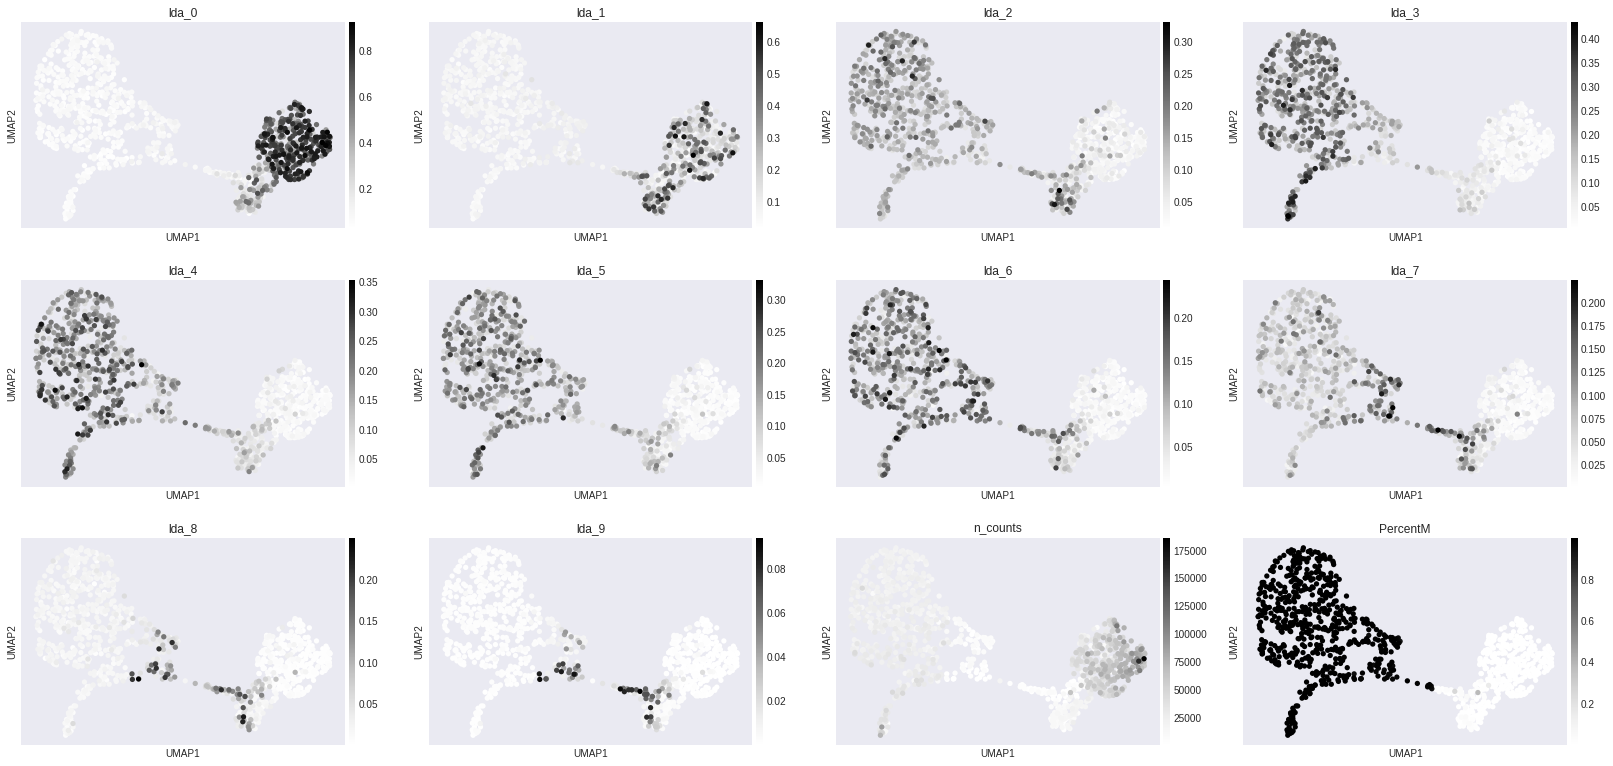

In [13]:
sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=100,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=5000,inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'])


sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts','PercentM'])


# In[ ]:

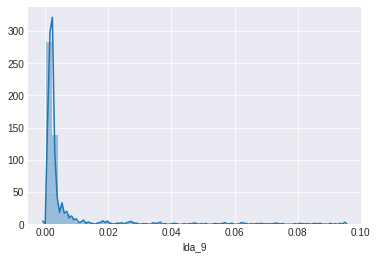

In [87]:
sns.distplot(freshadata.obs['lda_9'])

In [47]:
pbmcs = sc.read_10x_mtx(os.path.join('/home/mt/Downloads/PBMC_MMHG_Out/outs/filtered_feature_bc_matrix/'),cache=True)


Trying to set attribute `.var` of view, making a copy.


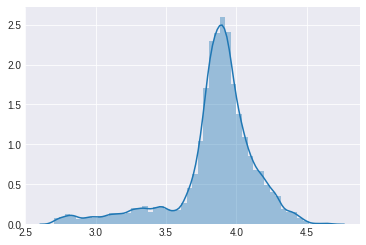

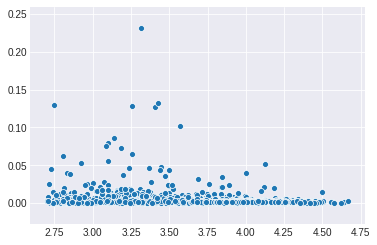

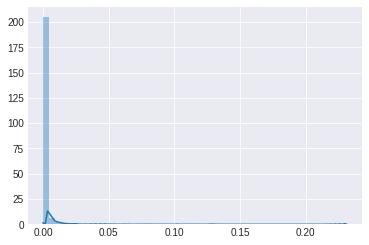

In [48]:
sc.pp.filter_genes(pbmcs, min_cells=50,inplace=True)
sc.pp.filter_cells(pbmcs,min_counts=500,inplace=True)
#adata=adata[adata.obs.n_counts.argsort(),:]
pbmcs.var['Mouse'] = ['mm10' in x for x in pbmcs.var.index]

pbmcs.obs['PercentM'] =pbmcs[:,list(pbmcs.var['Mouse'])].X.sum(1)/pbmcs.X.sum(1)

ambient_counts=np.log10(pbmcs[[x not in bcs for x in pbmcs.obs.index] ,:].X.sum(1).A1)
sns.distplot(ambient_counts)
plt.show()
sns.scatterplot(np.log10(pbmcs.X.sum(1).A1),np.array(pbmcs.obs['PercentM']))
plt.show()
sns.distplot(np.array(pbmcs.obs['PercentM']))
plt.show()


In [49]:
pbmcs.obs['PercentM']
pbmcs[:,pbmcs.var['Mouse']].X.sum()/pbmcs[:,np.invert(pbmcs.var['Mouse'])].X.sum()

0.001656911